In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dense, Flatten, Activation
from tensorflow.keras import Model
import numpy as np
from utils.data_manager import ClutteredMNIST
from utils.visualizer import plot_mnist_sample
from utils.visualizer import print_evaluation
from utils.visualizer import plot_mnist_grid
from components.STN import BilinearInterpolation

In [2]:
tf.__version__

'2.2.0-dev20200317'

## Spatial Transformer

In [3]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights


In [4]:
def build_model(input_shape=(60, 60, 1), sampling_size=(30, 30), num_classes=10):
    image = Input(shape=input_shape)
    locnet = MaxPool2D(pool_size=(2, 2))(image)
    locnet = Conv2D(20, (5, 5))(locnet)
    locnet = MaxPool2D(pool_size=(2, 2))(locnet)
    locnet = Conv2D(20, (5, 5))(locnet)
    locnet = Flatten()(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([image, locnet])
    x = Conv2D(32, (3, 3), padding='same')(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Conv2D(32, (3, 3))(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(2, 2))(x)
    x = Flatten()(x)
    x = Dense(256)(x)
    x = Activation('relu')(x)
    x = Dense(num_classes)(x)
    x = Activation('softmax')(x)
    return Model(inputs=image, outputs=x)
    

In [5]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60, 60, 1)]  0                                            
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 30, 30, 1)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 26, 26, 20)   520         max_pooling2d[0][0]              
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 13, 13, 20)   0           conv2d[0][0]                     
______________________________________________________________________________________________

## Dataset creation

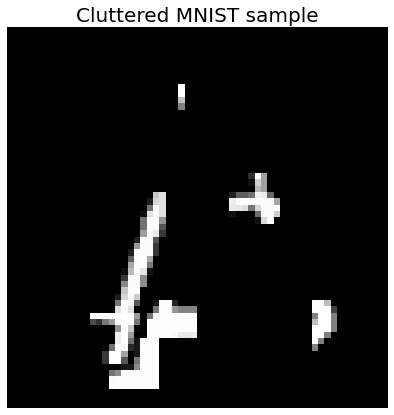

In [6]:
dataset_path = "./datasets/mnist_cluttered_60x60_6distortions.npz"
batch_size = 256
num_epochs = 30

data_manager = ClutteredMNIST(dataset_path)
train_data, val_data, test_data = data_manager.load()
x_train, y_train = train_data
plot_mnist_sample(x_train[7])

## Training

In [7]:
model.fit(x_train, y_train, batch_size=128, epochs=100)

Epoch 1/100
391/391 [==============================] - 39s 99ms/step - loss: 1.3358
Epoch 2/100
 21/391 [>.............................] - ETA: 35s - loss: 0.7312

KeyboardInterrupt: 

## Testing

In [8]:
input_image = model.input
output_STN = model.get_layer('bilinear_interpolation').output

STN_function = tf.keras.backend.function([input_image], [output_STN])

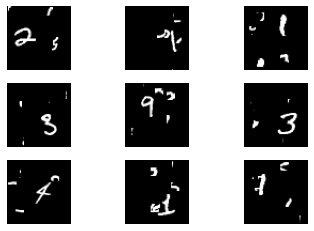

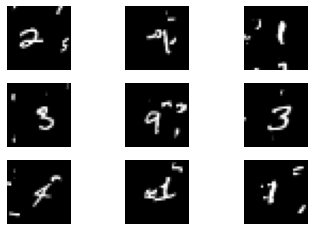

In [9]:
plot_mnist_grid(x_train[20:30])
plot_mnist_grid(x_train[20:30], STN_function)